In [1]:
from pypde import *
import matplotlib.pyplot as plt
initplot()


class Temperature(Integrator):
    CONFIG={
        "shape": (50,50),
        "bases": ("CN","CD"),
        "kappa": 1.0,
        "dt": 0.2,
        "ndim": 2,
        "tsave": 0.1,
    }
    def __init__(self,**kwargs):
        Integrator.__init__(self)
        self.__dict__.update(**self.CONFIG)
        self.__dict__.update(**kwargs)
        xbase = Base(self.shape[0],self.bases[0])
        ybase = Base(self.shape[1],self.bases[1])
        # Field
        self.field = Field( [xbase,ybase])
        # Boundary Conditions
        self.setup_fieldbc()
        # Solver
        self.setup_solver()
        # Initialize field
        self.init_field()
        self.field.save()
        
        # Space for derivatives
        xbase = Base(self.shape[0],"CH")
        ybase = Base(self.shape[1],"CH")
        self.deriv_field = Field( [xbase,ybase] )
        
    def setup_fieldbc(self):
        ''' Setup Inhomogeneous field'''
        # Boundary Conditions T 1, 0
        bc = np.zeros((self.shape[0],2))
        bc[:,0] =  0.5
        bc[:,1] = -0.5
        
        xbase = Base(self.shape[0],self.bases[0])
        ybase = Base(self.shape[1],self.bases[1])
        self.fieldbc = FieldBC([xbase,ybase],axis=1)
        self.fieldbc.add_bc(bc)
        
    def setup_solver(self):
        from pypde.templates.hholtz import solverplan_hholtz2d_adi
        self.solver = solverplan_hholtz2d_adi(
            bases=self.field.xs,lam=self.dt*self.kappa)
    
    def init_field(self):
        #self.field.v = -self.fieldbc.v
        self.field.v[:] = 0
        self.field.forward()
        self.field.backward()
    
    @property
    @memoized
    def bc_d2Tdz2(self):
        return grad(self.fieldbc,deriv=(0,2),return_field=False)
    
    @property
    @memoized
    def bc_dTdz(self):
        vhat =  grad(self.fieldbc,deriv=(0,1),return_field=False)
        return self.deriv_field.backward(vhat)
        
    
    def conv_term(self,ux,uz):
        conv = convective_term(self.field,ux,uz,
                              deriv_field = self.deriv_field,
                              add_bc = uz*self.bc_dTdz )
        return conv
                                 
    
    def update(self,ux,uz):
        ''' (1-D2)v = D2 v_bc + vold'''
            
            
        rhs = self.dt*self.kappa*self.bc_d2Tdz2
        rhs -= self.dt*self.conv_term(ux,uz)
        
        rhs  = self.solver.solve_rhs(  rhs )
        rhs += self.solver.solve_old(self.field.vhat)
        
        self.field.vhat[:] = self.solver.solve_lhs(rhs)
        
T  = Temperature(shape=shape)

set color cycle ...
register goldfish colorbar as 'gfcmap' ...
update rc params to default ...


NameError: name 'shape' is not defined

In [34]:
class Poisson(Integrator):
    CONFIG={
        "shape": (50,50),
        "bases": ("CN","CN"),
        "ndim": 2,
        "singular": True,
    }
    def __init__(self,**kwargs):
        Integrator.__init__(self)
        self.__dict__.update(**self.CONFIG)
        self.__dict__.update(**kwargs)
        
        # Field
        xbase = Base(self.shape[0],self.bases[0])
        ybase = Base(self.shape[1],self.bases[1])
        self.field = Field( [xbase,ybase])

        # Solver
        self.setup_solver()
        
        # Space for derivatives
        xbase = Base(self.shape[0],"CH")
        ybase = Base(self.shape[1],"CH")
        self.deriv_field = Field( [xbase,ybase] )
        
    def setup_solver(self):
        from pypde.templates.poisson import solverplan_poisson2d
        self.solver = solverplan_poisson2d(self.field.xs,
            singular=self.singular)
        
    def update(self,fhat):
        rhs  = self.solver.solve_rhs(fhat)
        self.field.vhat[:] = self.solver.solve_lhs(rhs)
        if self.singular:
            self.field.vhat[0,0] = 0

class Velocity_Ux(Integrator):
    CONFIG={
        "shape": (50,50),
        "bases": ("CD","CD"),
        "nu": 1.0,
        "dt": 0.2,
        "ndim": 2,
        "tsave": 0.1,
    }
    def __init__(self,**kwargs):
        Integrator.__init__(self)
        self.__dict__.update(**self.CONFIG)
        self.__dict__.update(**kwargs)
        xbase = Base(self.shape[0],self.bases[0])
        ybase = Base(self.shape[1],self.bases[1])
        # Field
        self.field = Field( [xbase,ybase])
        
        # Solver
        self.setup_solver()
        
        # Initialize field
        self.init_field()
        self.field.save()
        
        # Space for derivatives
        xbase = Base(self.shape[0],"CH")
        ybase = Base(self.shape[1],"CH")
        self.deriv_field = Field( [xbase,ybase] )
        
    def setup_solver(self):
        from pypde.templates.hholtz import solverplan_hholtz2d_adi
        self.solver = solverplan_hholtz2d_adi(
            bases=self.field.xs,lam=self.dt*self.nu)
    
    def init_field(self):
        self.field.v[:] = 0
        self.field.forward()
        self.field.backward()
    
    def conv_term(self,ux,uz):
        conv = convective_term(self.field,ux,uz,
                              deriv_field = self.deriv_field )
        return conv
    
    def update(self,ux,uz):
        ''' (1-D2)v = D vold'''

        rhs = -self.dt*self.conv_term(ux,uz)
        
        rhs  = self.solver.solve_rhs(  rhs )
        rhs += self.solver.solve_old(self.field.vhat)
        
        self.field.vhat[:] = self.solver.solve_lhs(rhs)

class Velocity_Uz(Integrator):
    CONFIG={
        "shape": (50,50),
        "bases": ("CD","CD"),
        "nu": 1.0,
        "dt": 0.2,
        "ndim": 2,
        "tsave": 0.1,
    }
    def __init__(self,**kwargs):
        Integrator.__init__(self)
        self.__dict__.update(**self.CONFIG)
        self.__dict__.update(**kwargs)
        xbase = Base(self.shape[0],self.bases[0])
        ybase = Base(self.shape[1],self.bases[1])
        # Field
        self.field = Field( [xbase,ybase])
        
        # Solver
        self.setup_solver()
        
        # Initialize field
        self.init_field()
        self.field.save()
        
        # Space for derivatives
        xbase = Base(self.shape[0],"CH")
        ybase = Base(self.shape[1],"CH")
        self.deriv_field = Field( [xbase,ybase] )
        
    def setup_solver(self):
        from pypde.templates.hholtz import solverplan_hholtz2d_adi
        self.solver = solverplan_hholtz2d_adi(
            bases=self.field.xs,lam=self.dt*self.nu)
    
    def init_field(self):
        self.field.v[:] = 0
        self.field.forward()
        self.field.backward()
    
    def conv_term(self,ux,uz):
        conv = convective_term(self.field,ux,uz,
                              deriv_field = self.deriv_field )
        return conv
    
    def update(self,ux,uz, That):
        ''' (1-D2)v = D vold'''

        rhs = self.dt*(-self.conv_term(ux,uz) + That) 
        
        rhs  = self.solver.solve_rhs(  rhs )
        rhs += self.solver.solve_old(self.field.vhat)
        
        self.field.vhat[:] = self.solver.solve_lhs(rhs)
        

In [133]:
#Accurate Projection Methods for theIncompressible Navier–Stokes Equations
#David L. Brown,§;1Ricardo Cortez,y;2and Michael L. Minionz


class NavierStokes(Integrator):
    CONFIG={
        "shape": (50,50),
        "kappa": 1.0,
        "nu": 1.0,
        "dt": 0.2,
        "ndim": 2,
        "tsave": 0.1,
    }
    def __init__(self,**kwargs):
        Integrator.__init__(self)
        self.__dict__.update(**self.CONFIG)
        self.__dict__.update(**kwargs)

        self.T  = Temperature(**self.__dict__)
        self.U  = Velocity_Ux(**self.__dict__)
        self.V  = Velocity_Uz(**self.__dict__)
        self.P  = Poisson(**self.__dict__)
        
        
        
        # Space for derivatives
        xbase = Base(self.shape[0],"CH")
        ybase = Base(self.shape[1],"CH")
        self.deriv_field = Field( [xbase,ybase] )
        
        # Additional pressure
        self.pres = Field( [xbase,ybase] )
        
        #
        self.set_temperature()
        
    def set_temperature(self):
        self.xx,self.yy = np.meshgrid(self.T.field.x,self.T.field.y,indexing="ij")
        self.T.field.v = np.sin(0.5*np.pi*self.xx)*np.cos(0.5*np.pi*self.yy)
        #self.T.field.v[:] = 0
        self.T.field.forward()
        #self.That = galerkin_to_cheby(self.T.field.vhat,self.T.field)
        #plt.contourf(xx,yy,self.T.field.v)
        #plt.show()
        
    def update_time(self):
        self.T.field.t += self.dt
        self.P.field.t += self.dt
        self.U.field.t += self.dt
        self.V.field.t += self.dt
        self.time += self.dt
        
    def save(self):
        self.T.field.save()
        self.P.field.save()
        self.U.field.save()
        self.V.field.save()
        
    def update_velocity(self,p,u,v,fac=1.0):
        dpdx = grad(p,deriv=(1,0),return_field=False)
        dpdz = grad(p,deriv=(0,1),return_field=False)
        u.vhat -= cheby_to_galerkin(dpdx*fac,self.U.field)
        v.vhat -= cheby_to_galerkin(dpdz*fac,self.V.field)
    
    def divergence_velocity(self,u,v):
        dudx = grad(u,deriv=(1,0),return_field=False)
        dudz = grad(v,deriv=(0,1),return_field=False)
        return dudx + dudz
    
    def update(self):
        # Buoyancy
        That = galerkin_to_cheby(self.T.field.vhat,self.T.field)
        That += galerkin_to_cheby(self.T.fieldbc.vhat,self.T.fieldbc)
        
        # Convection velocity
        self.U.field.backward()
        self.V.field.backward()
        ux = self.U.field.v
        uz = self.V.field.v
        
        # Add pressure term
        self.update_velocity(self.pres,self.U.field,self.V.field,fac=self.dt)
        
        # Solve Velocity
        self.U.update(ux,uz)
        self.V.update(ux,uz,That)
        
        # Divergence of Velocity
        dudx = grad(self.U.field,deriv=(1,0),return_field=False)
        dudz = grad(self.V.field,deriv=(0,1),return_field=False)
        div = self.divergence_velocity(self.U.field,self.V.field)#(dudx + dudz)
        
        # Solve Pressure
        self.P.update(div)
        
        # Update pressure
        self.pres.vhat += -1.0*self.dt*self.nu*div
        self.pres.vhat +=  1.0/self.dt*galerkin_to_cheby(self.P.field.vhat,self.P.field)
 
        # Correct Velocity
        self.update_velocity(self.P.field,self.U.field,self.V.field)
        
        #f = dudx[5:-5,5:-5] + dudz[5:-5,5:-5]
        #print("Divergence: {:4.2e}".format(np.linalg.norm(f)))
        
        # Solve Temperature
        self.T.update(ux,uz)
        
        

shape = (112,112)

Pr = 1
Ra = 1e4
nu = np.sqrt(Pr/Ra)
kappa = np.sqrt(1/Pr/Ra)

NS = NavierStokes(shape=shape,dt=0.05,tsave=1.0,nu=nu,kappa=kappa)
NS.update()
NS.update()
#NS.P.field.vhat
NS.iterate(45.0)
#NS.V.field.vhat


Time: 1.000
Time: 2.000
Time: 3.000
Time: 4.000
Time: 5.000
Time: 6.000
Time: 7.000
Time: 8.000
Time: 9.000
Time: 10.000
Time: 11.000
Time: 12.000
Time: 13.000
Time: 14.000
Time: 15.000
Time: 16.000
Time: 17.000
Time: 18.000
Time: 19.000
Time: 20.000
Time: 21.000
Time: 22.000
Time: 23.000
Time: 24.000
Time: 25.000
Time: 26.000
Time: 27.000
Time: 28.000
Time: 29.000
Time: 30.000
Time: 31.000
Time: 32.000
Time: 33.000
Time: 34.000
Time: 35.000
Time: 36.000
Time: 37.000
Time: 38.000
Time: 39.000
Time: 40.000
Time: 41.000
Time: 42.000
Time: 43.000
Time: 44.000
Time: 45.000


0.36411566462754513
Save animation to out/anim.mp4


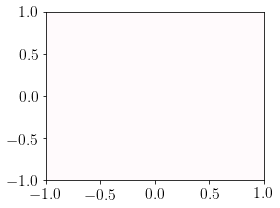

In [132]:
from IPython.display import HTML

print(NS.V.field.v.max())
anim = NS.V.field.animate(duration=4)
HTML(anim.to_jshtml())

#NS.V.field.v.max()

Save animation to out/anim.mp4


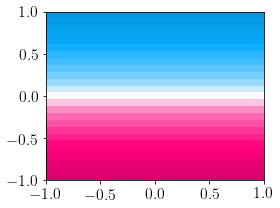

In [134]:
#  Add inhomogeneous part
for i,v in enumerate(NS.T.field.V):
        if NS.T.field.V[i][0,0] < 0.1:
            NS.T.field.V[i] += NS.T.fieldbc.v

anim = NS.T.field.animate(duration=4)
HTML(anim.to_jshtml())

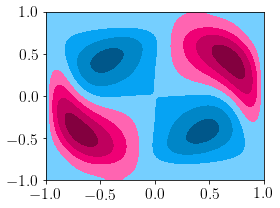

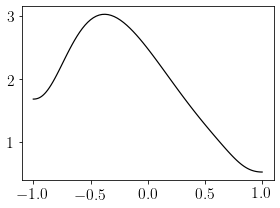

In [135]:
dTdz = grad(NS.T.field,deriv=(0,1),return_field=True)
dTdz.vhat += grad(NS.T.fieldbc,deriv=(0,1),return_field=False)
dTdz.backward()

NS.T.field.backward()
NS.V.field.backward()

uzT = NS.T.field.v*NS.V.field.v

Nu = 1/kappa*uzT - dTdz.v

xx,yy = np.meshgrid(NS.T.field.x,NS.T.field.y,indexing="ij")
plt.contourf(xx,yy,Nu)
plt.show()

plt.plot(NS.T.field.x, Nu[:,0])

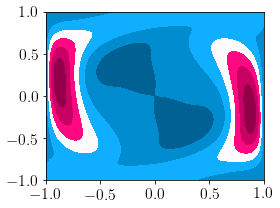

1.8486000909826696

In [137]:
Nu = np.zeros((NS.T.shape))
i=0

hist = []
for t,v in zip(NS.T.field.V,NS.V.field.V):    
    uzT = v*t
    dTdz = np.gradient(t,NS.T.field.y,axis=1)
    Nu = (Nu*i +  (uzT/kappa - dTdz))/(i+1)

    hist.append(np.sum(Nu[1:,0]*dx[:])/np.sum(dx))
    i+=1
    
#Nu = Nu/i
plt.contourf(xx,yy,Nu)
plt.show()

np.sum(Nu[1:,0]*dx[:])/np.sum(dx)

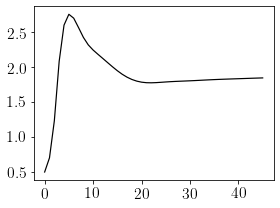

In [138]:
plt.plot(hist)

In [136]:
x = NS.T.field.x
dx = np.diff(x)
dx.shape

np.sum(Nu[1:,0]*dx[:])/np.sum(dx)

1.9444025248835684

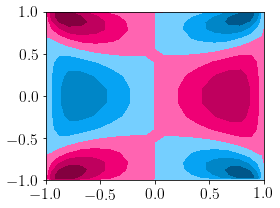

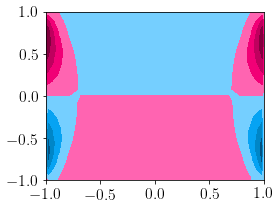

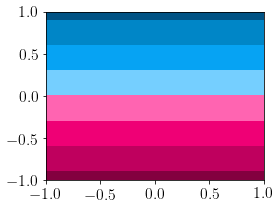

In [24]:
xx,yy = np.meshgrid(NS.T.field.x,NS.T.field.y,indexing="ij")

NS.V.field.backward()
NS.U.field.backward()
plt.contourf(xx,yy,NS.U.field.v)
plt.show()

plt.contourf(xx,yy,NS.V.field.v)
plt.show()

plt.contourf(xx,yy,NS.T.field.v)
plt.show()

In [2]:

xbase = Base(shape[0],"CN")
ybase = Base(shape[1],"CD")
    
T  = Temperature(shape=shape)
ux = Field([xbase,ybase])
uz = Field([xbase,ybase])

x,y = T.field.x, T.field.y
xx,yy = np.meshgrid(x,y,indexing="ij")

m,n = 1,1
ux.v =  2*np.cos(0.5*m*np.pi*xx)*np.sin(1.0*n*np.pi*yy)
uz.v = -2*np.sin(1.0*m*np.pi*xx)*np.cos(0.5*n*np.pi*yy)



In [3]:
#%%time
D = Temperature(shape=shape,dt=0.002,tsave=0.5,kappa=0.01)
D.iterate(5.0,ux_field = ux.v, uz_field=uz.v)

Time: 0.500
Time: 1.000
Time: 1.500
Time: 2.000
Time: 2.500
Time: 3.000
Time: 3.500
Time: 4.000
Time: 4.500
Time: 5.000
